In [1]:
from fastai.vision import *
import os
import glob
from tqdm import tqdm_notebook

print(torch.cuda.is_available())
print(os.getcwd())
torch.cuda.empty_cache()

True
/home/lh2910


In [2]:
labels = pd.read_csv('/home/lh2910/list_attr_celeba.csv')
labels.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [3]:
os.chdir('/home/lh2910/faces')
path = os.getcwd()
extracted_faces = glob.glob('*.jpg')
extracted_faces.sort()

A = set(extracted_faces)
slices = []
for i in labels.loc[:, 'image_id']:
    if i in A:
        slices.append(True)
    else:
        slices.append(False)

attractive = labels.loc[slices, ['image_id', 'Attractive', 'Male']]
attractive.head()

,image_id,Attractive,Male
0,000001.jpg,1,-1
1,000002.jpg,-1,-1
4,000005.jpg,1,-1
5,000006.jpg,1,-1
6,000007.jpg,1,1


In [4]:
attractive_female = attractive.loc[attractive.Male == -1, :]
attractive_female.head()

,image_id,Attractive,Male
0,000001.jpg,1,-1
1,000002.jpg,-1,-1
4,000005.jpg,1,-1
5,000006.jpg,1,-1
8,000009.jpg,1,-1


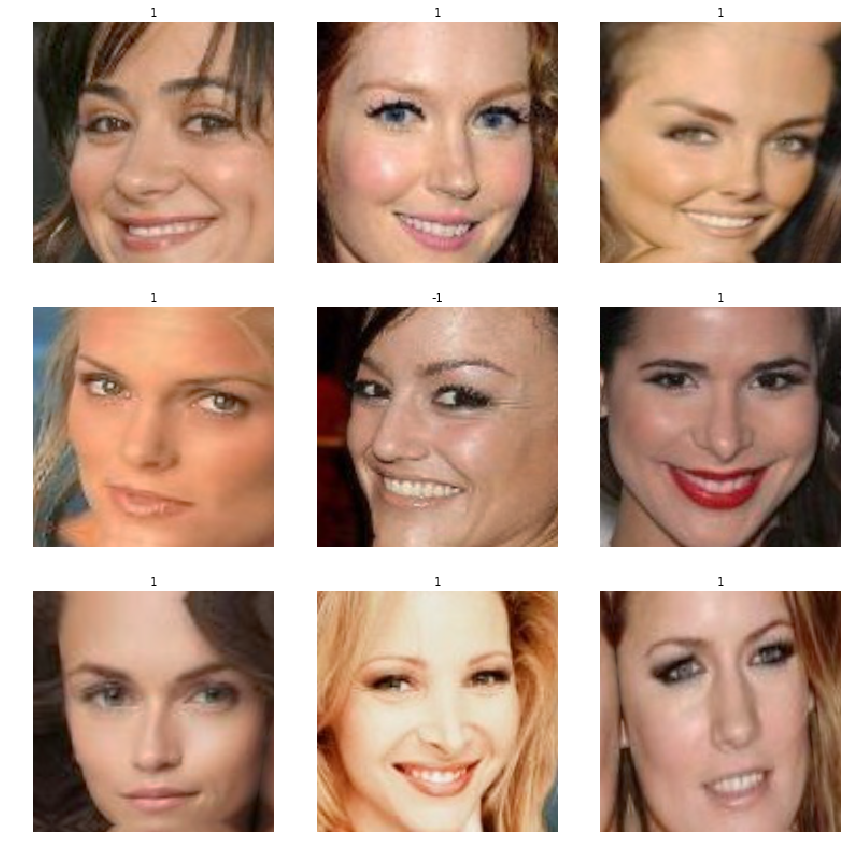

In [5]:
tfms = get_transforms(do_flip=True, flip_vert=False,
                      p_affine=.75, p_lighting=.75,
                      max_lighting=.2, max_rotate=10, max_warp=.2, max_zoom=1.1)

data = (ImageList.from_df(attractive_female, path=path)
        .split_by_rand_pct(.05)
        .label_from_df(cols=1)
        .transform(tfms, size=224)
        .databunch()
        .normalize())
        
data.show_batch(rows=3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02


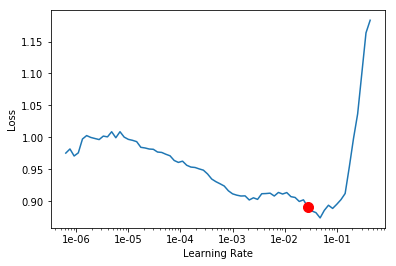

In [6]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy])
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [7]:
# lr = 1e-3
# learn.fit_one_cycle(1, slice(lr))

In [8]:
# https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L190
 # uses defaults.lr = slice(3e-3)
learn.fit(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.379300,0.398745,0.814382,23:07
1,0.378007,0.372170,0.824270,23:01
2,0.369391,0.355674,0.826292,23:01
3,0.350387,0.360205,0.830562,23:00
4,0.354371,0.349337,0.833483,23:00


In [9]:
# Save/Load as .pth

# To Save
learn.save('/home/lh2910/models/attractive_female_resnet50')

# To Load
# data = ... 
# learn = cnn_learner(data, models.resnet50, pretrained=False)
# learn.load(path+'/models/male_resnet50')

In [10]:
# Save/Load as .pkl

# To Save
learn.export('/home/lh2910/models/attractive_female_resnet50.pkl')

# To Load
# learn = load_learner(path+'/models', 'male_resnet50.pkl')

In [11]:
# learn.model.eval()

Label: 1
Prediction: (Category 1, tensor(1), tensor([0.2972, 0.7028]))


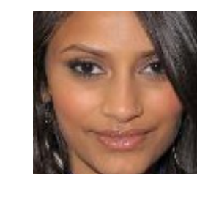

In [12]:
img, category = data.valid_ds[150]
print('Label:', category)
print('Prediction:', learn.predict(img))
img.show()